# 4.10. Interpretación de los gráficos de colores de esfuerzos y deformaciones

Por:
- Michael Heredia Pérez
- [mherediap@unal.edu.co](mherediap@unal.edu.co)
- 2026-02-22

In [73]:
# Importamos las librerías necesarias

import numpy as np
import matplotlib.pyplot as plt
import os

# Para modificar el tamaño de la colorbar.
from mpl_toolkits.axes_grid1 import make_axes_locatable     

## Configuración previa

Primero, definimos algunos parámetros en la librería matplotlib para darle estilo al texto de la gráfica. 

In [74]:
import matplotlib as mpl

# Configure matplotlib for STIX font - comprehensive setup
mpl.rcParams.update({
    # Primary font configuration
    "font.family": "serif",              # Use serif family
    "font.serif": ["STIX", "STIXGeneral", "STIX Two Text"], # STIX font priority
    "mathtext.fontset": "stix",          # Math expressions in STIX
    
    # Explicit font specification for all text elements
    "axes.labelsize": 18,
    "axes.titlesize": 18, 
    "legend.fontsize": 16,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "font.size": 16,
    
    # Line properties
    "lines.linewidth": 1.5
})

Vamos a realizar muchas figuras, una por cada esfuerzo estudiado. Así que creamos una función para impirmir estas figuras. 

In [75]:
def save_image(fig, file_name, directory="results_plots", formats=("pdf","eps","png"), dpi=300):
    """
    Save the given Matplotlib figure in multiple formats.

    Args:
        fig (matplotlib.figure.Figure): 
            The Matplotlib figure to save.
        file_name (str): 
            The base name of the file (without extension).
        directory (str): Default 300
            The directory where the files will be saved.
        formats (tuple): Default ("pdf", "eps", "png").  
            The formats to save the figure.
        dpi (int): Default 300.
            The resolution of the saved images in dots per inch (DPI).
            
    Prints:
        Saving confirmation. "Figure saved to: <output_file>"
    """
    # Ensure the directory exists
    os.makedirs(directory, exist_ok=True)

    # Save the figure in all specified formats
    for fmt in formats:
        full_path = os.path.join(directory, f"{file_name}.{fmt}")
        fig.savefig(full_path, bbox_inches="tight", dpi=dpi)
        print(f"Figure saved to: {full_path}")

In [76]:
def plot_esf_def(variable, titulo, nombre, angulo = None, cmap="RdBu_r"):
    """
    Grafica esfuerzos/deformaciones sobre una malla (x,y) y ajusta el layout
    para que no quede apretado, sin tocar rcParams globales.

    Args:
        variable (np.ndarray): 
            campo a graficar (misma forma que x,y).
        titulo (str): 
            título del gráfico.
        nombre (str): 
            Nombre de la figura al ser guardada.
        angulo (np.ndarray | list[np.ndarray] | None): 
            ángulos para quiver.
        cmap (str): 
            colormap. 
            Recomendados: coolwarm, RdBu_r, vik (requiere ScientificColourMaps).
    """
    # Defino las coordenadas x, y como globales.
    global x, y

    # Creo el lienzo.
    fig, ax = plt.subplots(figsize=(10, 3), constrained_layout=True)
    
    # Coloreo el gráfico según la variable.
    im = ax.contourf(x, y, variable, 60, cmap = cmap, alpha=0.8)
    
    # Grafico las curvas de nivel.
    ax.contour(x, y, variable, 20, colors="black", linewidths=0.5, 
               linestyles="solid")
    
    # Creo un axes adicional a la derecha en donde va la escala de colores.
    divider = make_axes_locatable(ax)
    
    # Creo la escala de colores.
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    # Configuro la escala para mostrar 5 intervales/4 etiquetas.
    fig.colorbar(im, cax=cax).ax.locator_params(nbins=5)
        
    # Para los esfuerzos principales se grafican las líneas que indiquen las
    # direcciones de los esfuerzos en cada nodo de la malla
    
    # Si se da un array para los ángulos. 
    if angulo is not None:
        # Se verifica que sea de tipo array numpy y se castea a lista. 
        if isinstance(angulo, np.ndarray):
            angulo = [angulo]
        for ang in angulo:
            ax.quiver(
                # Las coordenadas de la malla.
                x, y, 
                # Las direcciones.
                variable*np.cos(ang), variable*np.sin(ang), 
                # Configura cómo se grafican.
                headwidth=0, headlength=0, headaxislength=0, pivot='middle', 
                linewidths=2
                )
    
    # Se especifican los ejes y el título, y se colocan los ejes iguales.
    ax.set_xlabel("$x$ [m]")
    ax.set_ylabel(f"{titulo}\n$y$ [m]", rotation = 90)
    #ax.set_title(titulo)
    ax.set_aspect("equal", adjustable="box")   

    # Muestro la gráfica
    plt.show()
    
    # Almaceno el gráfico en formato .png, .pdf y .eps
    save_image(fig, nombre)

## Formulación.

Definimos las constantes de nuestro problema.

In [77]:
# Propiedades geométricas de la viga.
c = 0.50    # m, altura = 2c.
L = 3.00    # m, luz    = 2L.
t = 1.00    # m, espesor unitario.

# Se calcula el momento de inercia centroidal I = bh^3/12, con b=1 y h=2c.
I = (t * (2*c)**3) / 12 # m^4.

# Carga aplicada
q = -10.0   # kN/m.

# Propiedades del material
E  = 21e6         # kPa = 21 GPa, módulo de Young.
nu = 0.23         # ad          , coeficiente de Poisson.
G = E/(2*(1+nu))  # kPa         , módulo de cortante.

## Análisis

Las funciones que determinan el estado de esfuerzos de la viga, fueron calculadas al solucionar la función de tensión de Airy. Estas ecuaciones las resolveremos en una discretización de la viga. 

In [78]:
# Se crea la grilla de puntos donde se harán los cálculos.
nnds_x = 50
nnds_y = 20
x, y = np.meshgrid( np.linspace(-L, L, nnds_x), np.linspace(-c, c, nnds_y) )

# Se definen los esfuerzos (en tensión plana sz = txz = tyz = 0), eq (4.45)
sx  = -(q/(2*I))*(x**2*y - 2*y**3/3 + 2*c**2*y/5 - L**2*y)
sy  = -(q/(2*I))*(y**3/3 - c**2*y - 2*c**3/3)
txy = -(q/(2*I))*(c**2 - y**2)*x

# Se calculan las deformaciones.
ex  = (1/E)*(sx - nu*sy)
ey  = (1/E)*(sy - nu*sx)
ez  = -(nu/E)*(sx + sy)
gxy = txy/G

# Se calculan los esfuerzos principales, los esfuerzos cortantes máximos y sus 
# ángulos.
tmax = np.sqrt( ((sx - sy)/2)**2 + txy**2 )
s1 = (sx + sy)/2 + tmax
s2 = (sx + sy)/2 - tmax
t1 = np.arctan2(2*txy, sx-sy)/2     
t2 = t1 + np.pi/2                   # t1 + 90°

## Gráficos de esfuerzos $\sigma_x$, $\sigma_y$, $\tau_{xy}$

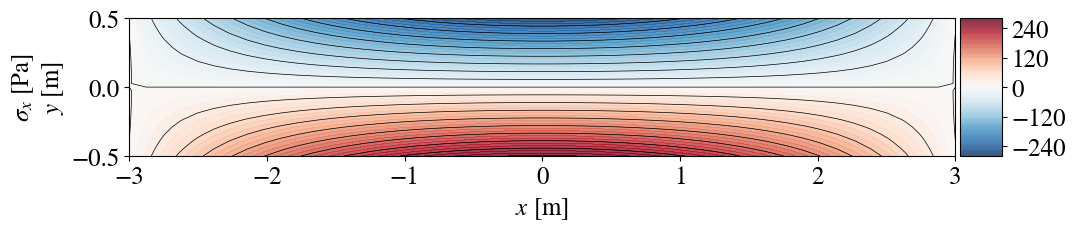

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Figure saved to: results_plots/sigma_x.pdf
Figure saved to: results_plots/sigma_x.eps
Figure saved to: results_plots/sigma_x.png


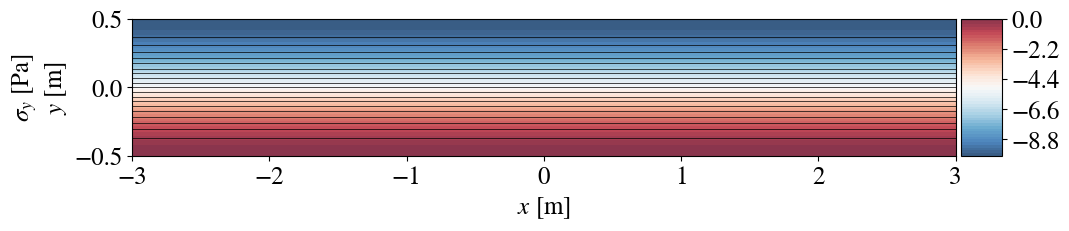

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Figure saved to: results_plots/sigma_y.pdf
Figure saved to: results_plots/sigma_y.eps
Figure saved to: results_plots/sigma_y.png


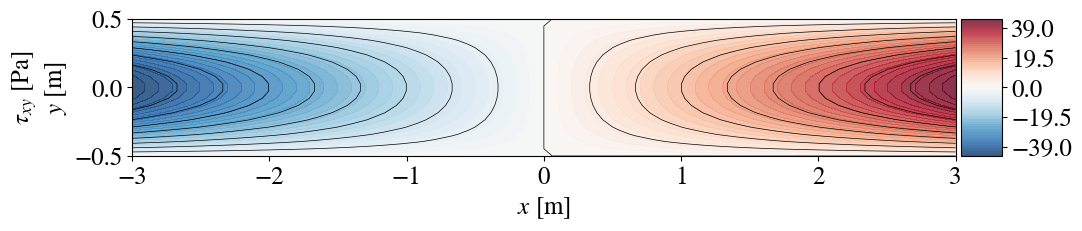

Figure saved to: results_plots/tau_xy.pdf


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Figure saved to: results_plots/tau_xy.eps
Figure saved to: results_plots/tau_xy.png


In [79]:
plot_esf_def(sx,  r"$\sigma_x$ [Pa]", "sigma_x")
plot_esf_def(sy,  r"$\sigma_y$ [Pa]", "sigma_y")
plot_esf_def(txy, r"$\tau_{xy}$ [Pa]", "tau_xy")

## Gráficos de deformaciones $\varepsilon_x$, $\varepsilon_y$, $\varepsilon_z$, $\gamma_{xy}$

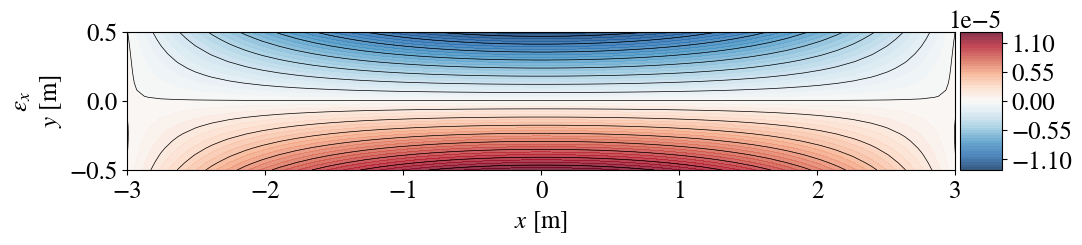

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Figure saved to: results_plots/epsilon_x.pdf
Figure saved to: results_plots/epsilon_x.eps
Figure saved to: results_plots/epsilon_x.png


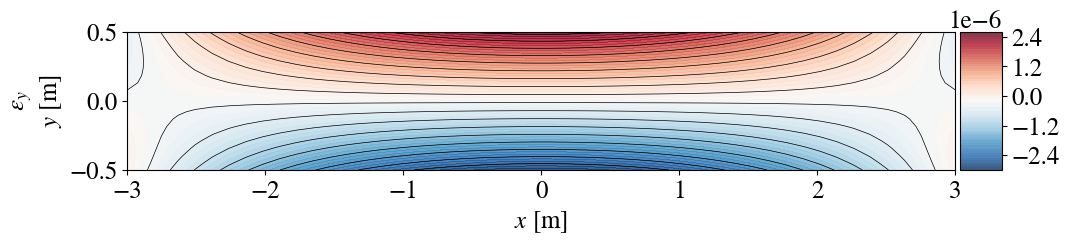

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Figure saved to: results_plots/epsilon_y.pdf
Figure saved to: results_plots/epsilon_y.eps
Figure saved to: results_plots/epsilon_y.png


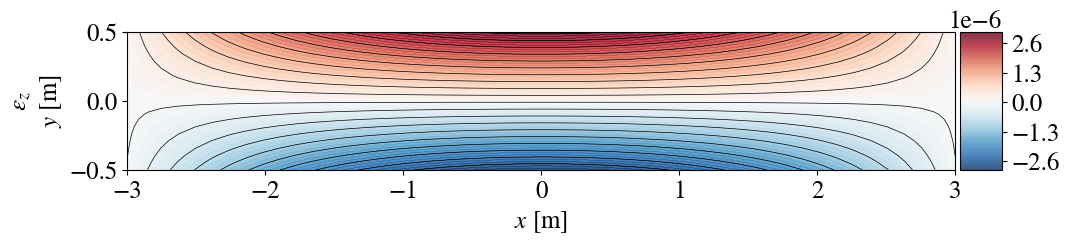

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Figure saved to: results_plots/epsilon_z.pdf
Figure saved to: results_plots/epsilon_z.eps
Figure saved to: results_plots/epsilon_z.png


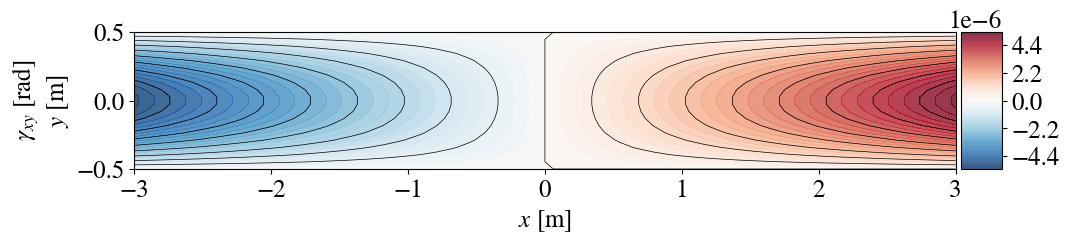

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Figure saved to: results_plots/gamma_xy.pdf
Figure saved to: results_plots/gamma_xy.eps
Figure saved to: results_plots/gamma_xy.png


In [80]:
plot_esf_def(ex,  r"$\epsilon_x$", "epsilon_x")
plot_esf_def(ey,  r"$\epsilon_y$", "epsilon_y")
plot_esf_def(ez,  r"$\epsilon_z$", "epsilon_z")
plot_esf_def(gxy, r"$\gamma_{xy}$ [rad]", "gamma_xy")

## Gráficos de los esfuerzos principales con sus direcciones

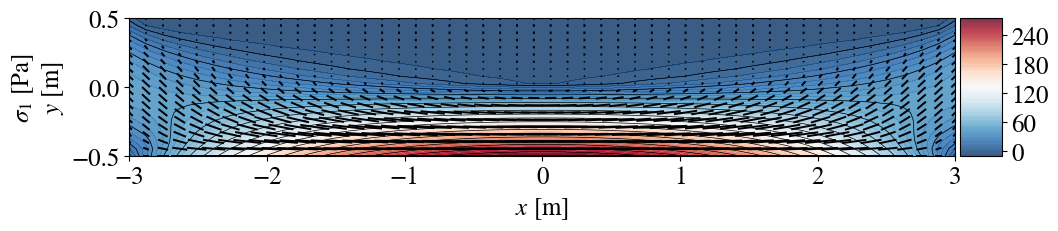

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Figure saved to: results_plots/s1.pdf
Figure saved to: results_plots/s1.eps
Figure saved to: results_plots/s1.png


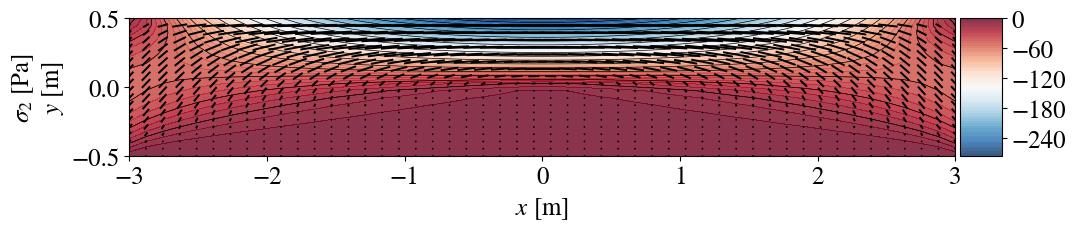

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Figure saved to: results_plots/s2.pdf
Figure saved to: results_plots/s2.eps
Figure saved to: results_plots/s2.png


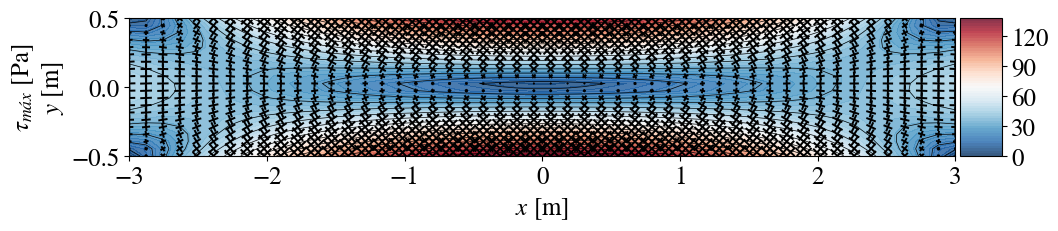

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Figure saved to: results_plots/tmax.pdf
Figure saved to: results_plots/tmax.eps
Figure saved to: results_plots/tmax.png


In [81]:
plot_esf_def(s1,   r"$\sigma_1$ [Pa]", "s1", t1)
plot_esf_def(s2,   r"$\sigma_2$ [Pa]", "s2", t2)
plot_esf_def(tmax, r"$\tau_{máx}$ [Pa]", "tmax", [t1-np.pi/4, t1+np.pi/4])

## Diagramas de fuerza cortante y momento flector

Adicionalmente, podemos obtener los diagramas de fuerza cortante y momento flector asociados, a partir de las siguientes ecuaciones:

$$
V(x)=q\,x
$$

$$
M(x)=-\frac{q}{2}\left(L^2-x^2\right)
$$

Nuevamente, por organización, deifnimos una función para realizar los gráficos de las fuerzas internas.

In [82]:
def plot_v_m(distancia, fuerza, titulo, nombre):
    """
    Grafica el diagrama unidimensional de fuerza cortante V(x) o 
    momento flector M(x) a lo largo de la viga.

    Args:
        distancia (np.ndarray): 
            Vector 1D con las coordenadas longitudinales x [m].
        fuerza (np.ndarray): 
            Vector 1D con los valores de la función interna evaluada 
            en cada punto de 'distancia'. 
        titulo (str): 
            Título del gráfico (admite sintaxis LaTeX).
        nombre (str): 
            Nombre base del archivo al guardar la figura. 
    """
    
    fig, ax = plt.subplots(figsize=(10, 3), constrained_layout=True)
    
    ax.plot(distancia, fuerza, "-b")
    ax.axhline(0, linewidth=0.8)
    ax.axvline(0, linewidth=0.8)
    ax.set_xlabel(r"$x$ [m]")
    ax.set_title(titulo)
    ax.grid(True)
    
    if nombre=="fuerza_cortante":
        ax.set_ylabel(r"$V(x)$ [kN]")
    if nombre=="momento_flector":
        ax.set_ylabel(r"$M(x)$ [kN$\cdot$m]")

    plt.show()
    save_image(fig, nombre)

Calculamos las fuerzas internas en la longitud de la viga.

In [83]:
# Dominio 1D a lo largo de la luz: x ∈ [-L, L]
nx = 400
x1d = np.linspace(-L, L, nx)

# Funciones internas
V = q * x1d
M = -(q/2.0) * (L**2 - x1d**2)

Graficamos la fuerza cortante y el momento flector.

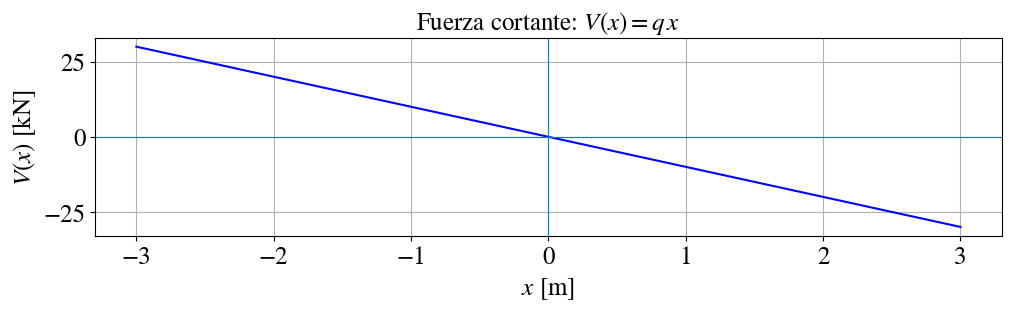

Figure saved to: results_plots/fuerza_cortante.pdf
Figure saved to: results_plots/fuerza_cortante.eps
Figure saved to: results_plots/fuerza_cortante.png


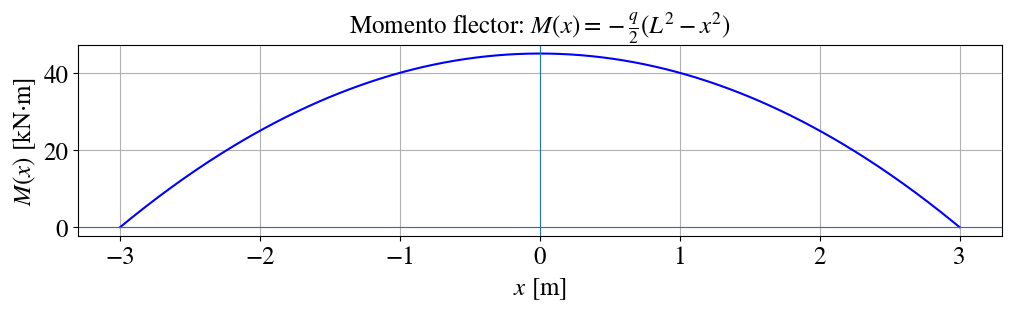

Figure saved to: results_plots/momento_flector.pdf
Figure saved to: results_plots/momento_flector.eps
Figure saved to: results_plots/momento_flector.png


In [84]:
plot_v_m(x1d, V, r"Fuerza cortante: $V(x)=q\,x$", "fuerza_cortante")
plot_v_m(x1d, M, r"Momento flector: $M(x)=-\frac{q}{2}\left(L^2-x^2\right)$", "momento_flector")

Fin :)